In [1]:
# Long Short-Term Memory (LSTM) is a type of recurrent neural network (RNN) designed to handle sequential data.
# making it suitable for tasks like language modeling, time series prediction, and speech recognition. 

# Key Concepts:

# Memory Cells: Store information over long periods, which helps in capturing long-term dependencies.
# Forget Gate: Decides what information to discard.
# Input Gate: Decides what new information to add to the cell state.
# Output Gate: Controls what part of the cell state should be output

# When to Use LSTM:

# When the data shows non-linear trends and complex patterns.
# For long-term forecasting, especially with large datasets.
# Useful in natural language processing, stock price prediction, and other time series applications.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense , Dropout

In [3]:
# Load the dataset
data = pd.read_csv("../../datasets/wipro_eq_stock.csv")

# Display the first few rows of the dataset
data.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,04-01-2010,WIPRO,EQ,680.00,685.0,697.0,675.95,696.35,693.80,691.08,767166,5.300000e+13,NaN,433411,0.5650
1,05-01-2010,WIPRO,EQ,693.80,696.3,708.0,693.55,707.85,704.75,699.33,1120433,7.840000e+13,NaN,706061,0.6302
2,06-01-2010,WIPRO,EQ,704.75,706.0,710.0,687.00,693.00,690.50,693.46,1029382,7.140000e+13,NaN,590142,0.5733
3,07-01-2010,WIPRO,EQ,690.50,695.0,695.5,675.00,678.00,678.25,679.45,1031096,7.010000e+13,NaN,572349,0.5551
4,08-01-2010,WIPRO,EQ,678.25,679.0,680.0,666.00,666.40,668.05,669.69,642789,4.300000e+13,NaN,270355,0.4206


In [4]:
# Drop irrelevant columns and handle missing values
data = data.drop(columns=["Symbol", "Series", "Prev Close", "Last", "VWAP", "Turnover", "Trades", "Deliverable Volume", "%Deliverble"])
# Check for missing values
print("Missing values\n" , data.isnull().sum())

Missing values
 Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


In [5]:
# Convert Date to datetime and sort by date
data["Date"] = pd.to_datetime(data["Date"], format="%d-%m-%Y")
data = data.sort_values(by="Date").reset_index(drop=True)

print("First 5 rows after sorting \n " , data.head())

First 5 rows after sorting 
          Date   Open   High     Low   Close   Volume
0 2010-01-04  685.0  697.0  675.95  693.80   767166
1 2010-01-05  696.3  708.0  693.55  704.75  1120433
2 2010-01-06  706.0  710.0  687.00  690.50  1029382
3 2010-01-07  695.0  695.5  675.00  678.25  1031096
4 2010-01-08  679.0  680.0  666.00  668.05   642789


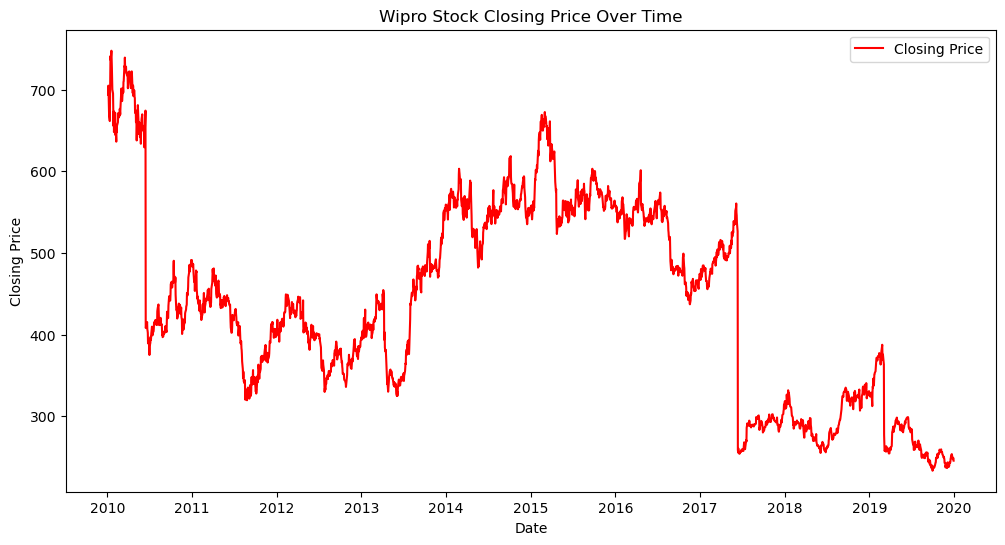

In [6]:
# Plot the closing price over time
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Close'], label='Closing Price', color='red')
plt.title('Wipro Stock Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

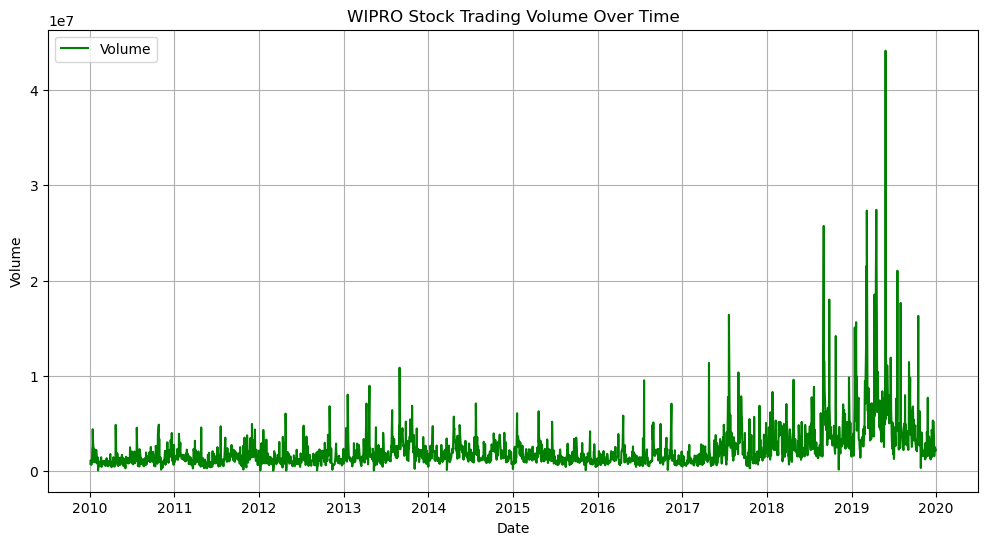

In [7]:
# Plot the volume over time
plt.figure(figsize=(12, 6))
plt.plot(data["Date"], data["Volume"], label="Volume", color="green")
plt.title("WIPRO Stock Trading Volume Over Time")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.legend()
plt.grid(True)
plt.show()

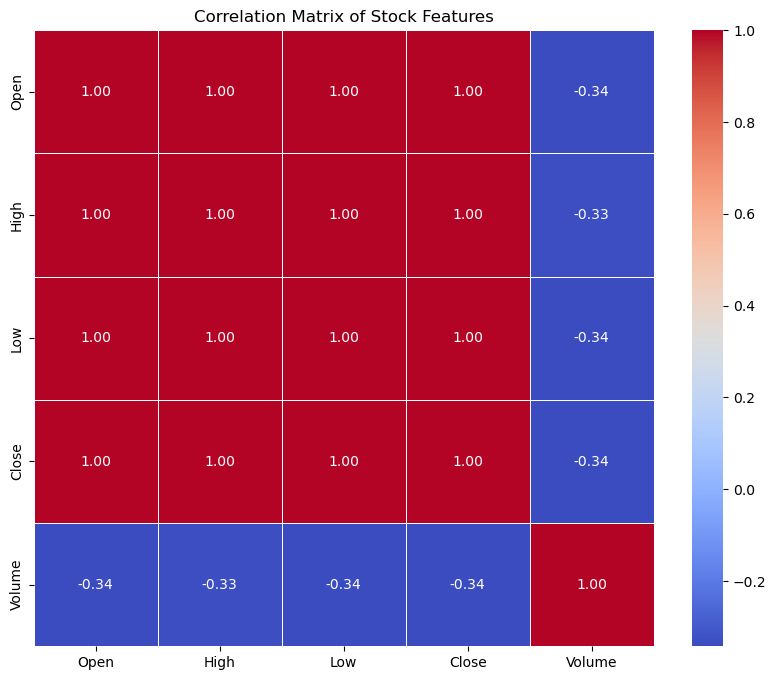

10      747.50
8       741.10
50      739.10
11      738.95
9       735.90
         ...  
2423    237.05
2461    236.80
2418    236.60
2421    235.85
2420    233.50
Name: Close, Length: 2481, dtype: float64

In [8]:
# Calculate correlation matrix
correlation_matrix = data[["Open", "High", "Low", "Close", "Volume"]].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sb.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Stock Features')
plt.show()
data['Close'].sort_values(ascending=False)

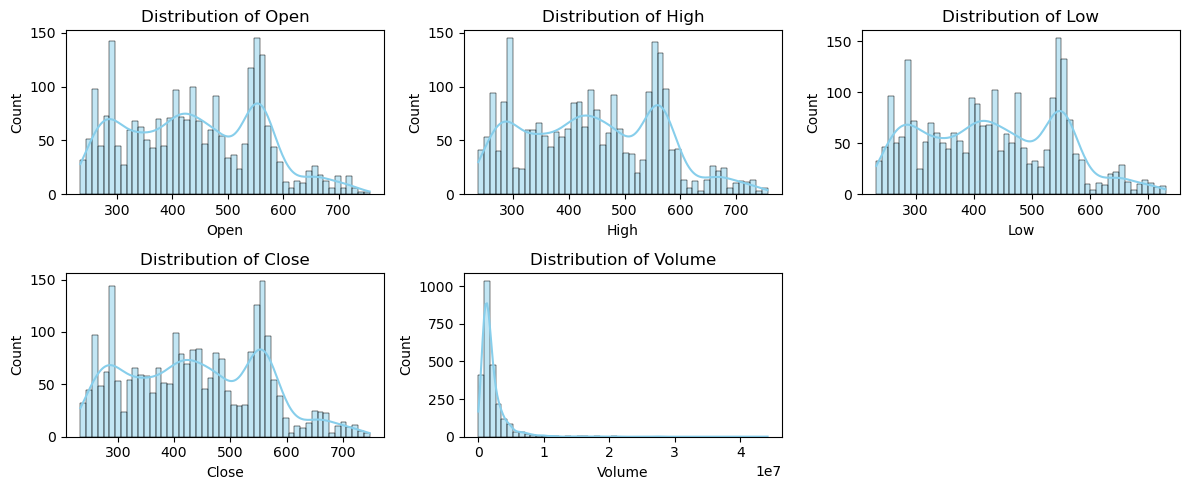

In [9]:
# Plot distribution 
key_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
plt.figure(figsize=(12, 5))
for i, col in enumerate(key_columns):
    plt.subplot(2, 3, i + 1)
    sb.histplot(data[col], bins=50, kde=True, color='skyblue')
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()


In [10]:
# Select depedant var for LSTM modeling
data_close = data[["Close"]].values

In [11]:
#  Transform the values in our data with help of the fit_transform function. Min-max scaler is used for scaling the data so that we can bring all the price values to a common scale. 

# Feature scaling to normalize the feature
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data =  scaler.fit_transform(data_close)

In [12]:
# Converting the time series data [stationary test] into sequences that the LSTM model can learn from.
def create_sequences(data, lookback=60): #  Specifies that the model will look at the previous 60 days to predict the next price.
    X, y = [], [] 
    # X – Sequence of the previous 60 days' scaled data. and  y – Corresponding Close price (target) for the next day.
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i, 0])  # Previous 60 days' data as input
        y.append(data[i, 0])             # Next day's price as target
    return np.array(X), np.array(y)

In [13]:
X, y = create_sequences(scaled_data, 60) # Generating Sequences for Model Training

In [14]:
# Reshaping X for LSTM Input 
# reshape(samples, timesteps, features)
X = X.reshape((X.shape[0], X.shape[1], 1)) 


In [15]:
# split into training and testing
train_size = int(len(X) * 0.75)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [16]:
# final shape of dataset before LSTM
print("xtrain= ",X_train.shape , "\txtest= ", X_test.shape , "\nytrain =", y_train.shape , "\tytest= ", y_test.shape)


xtrain=  (1815, 60, 1) 	xtest=  (606, 60, 1) 
ytrain = (1815,) 	ytest=  (606,)


In [17]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Final output layer

In [18]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [19]:
# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: 0.0508 - val_loss: 0.0043
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0047 - val_loss: 0.0010
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0046 - val_loss: 7.6880e-04
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0045 - val_loss: 8.8273e-04
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0038 - val_loss: 7.4037e-04
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0036 - val_loss: 6.3217e-04
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0032 - val_loss: 0.0010
Epoch 8/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0038 - val_loss: 6.5682e-04
Epoch 9/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0037 - val_loss: 5.6736e-04
Epoch 10/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0031 - val_loss: 8.7258e-04
Epoch 11/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0027 - val_loss: 3.9948e-04
Epoch 12/20
57/57 ━━━━━━━━━━━━━

In [20]:
# prediction
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))  # Inverse scale
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))  # Inverse scale for comparison

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# Calculate Evaluation Metrics
mse = mean_squared_error(y_test_actual, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_actual, predictions)
r2 = r2_score(y_test_actual, predictions)

# Print Results
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R2): {r2:.4f}")

Mean Squared Error (MSE): 82.0644
Root Mean Squared Error (RMSE): 9.0589
Mean Absolute Error (MAE): 5.2731
R-squared (R2): 0.9158


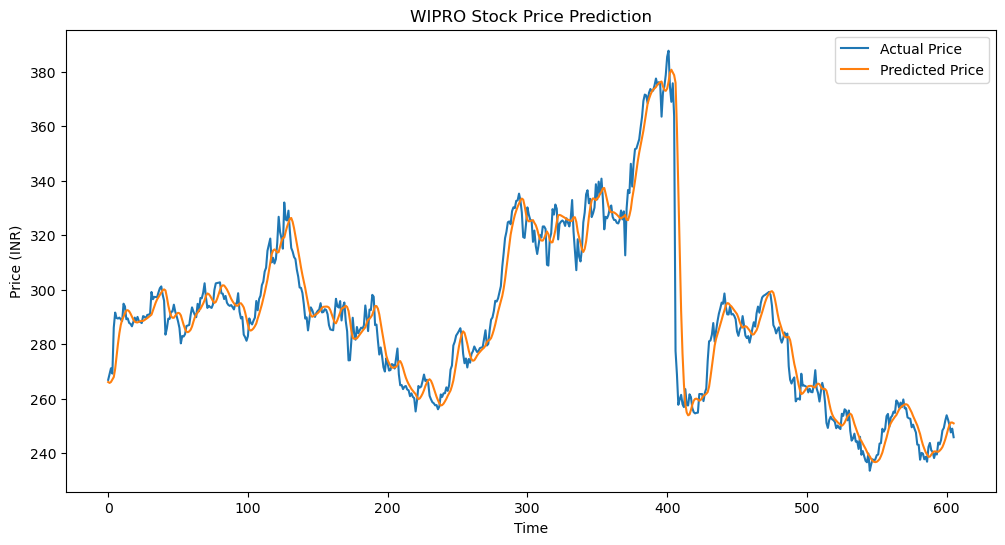

In [22]:
# plot the graph for actual values vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label="Actual Price")
plt.plot(predictions, label="Predicted Price")
plt.title("WIPRO Stock Price Prediction")
plt.xlabel("Time")
plt.ylabel("Price (INR)")
plt.legend()
plt.show()
